## Function Definitions

In [4]:
import timeit
from numba import njit
import pandas as pd
import numpy as np
from datetime import datetime


## Generate a dataset 

In [2]:
strings = {0: "run",
          1: "fly",
          2: "walk",
          3: "sprint",
          4: "job",
          5: "trot"}

str_func = lambda x: strings[x]

data_range = np.arange(1600000000, 1603000000, 1)
random_range_1 = 100*np.random.rand(len(data_range))
random_range_2 = 200*np.random.rand(len(data_range))
vfunc = np.vectorize(str_func)
string_range = vfunc(np.random.randint(6, size=len(data_range)))
df = pd.DataFrame({"ts": data_range, "vals_1": random_range_1, "strs": string_range, "vals_2": random_range_2,})

## Read and write

In [5]:
# Individual runtime tests

print("Testing an excel upload")
# Dont run this actually, super slow
%timeit df[0:200000].to_excel("big_data/dataset.xlsx", index=False)
print("Testing an CSV upload")
%timeit df.to_csv("big_data/dataset.csv", index=False)
print("Testing an parquet upload")
%timeit df.to_parquet("big_data/dataset.parquet", index=False)

Testing an excel upload
30.8 s ± 7.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Testing an CSV upload
11 s ± 2.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Testing an parquet upload
614 ms ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Individual runtime tests

print("Testing an excel read")
# Dont run this actually, super slow
%timeit pd.read_excel("big_data/dataset.xlsx")
print("Testing an CSV read")
%timeit pd.read_csv("big_data/dataset.csv")
print("Testing an parquet read")
%timeit pd.read_parquet("big_data/dataset.parquet")

Testing an excel read
22 s ± 2.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Testing an CSV read
1.28 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Testing an parquet read
292 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
# Profiling several loads

def test_runtime(func, args=[], kwargs={}):
    # Test runtime, but we will use timeit function
    test = datetime.now()
    output = func(*args, **kwargs)
    elapsed = datetime.now() - test
    print(f"Function ran in {datetime.now() - test}")
    return output, elapsed


# Using generators for memory safe iterations - only stores the state and keeps the cache clean
#
#   def func(iters):
#      for iter in iters:
#          yield something
#

def profile_runtimes(all_funcs, all_args, all_kwargs):
    # Test set of loadtimes and return as a 
    for func, args, kwargs in zip(all_funcs, all_args, all_kwargs):
        test = datetime.now()
        output = func(*args, **kwargs)
        elapsed = datetime.now() - test
        yield elapsed
    
upper_bounds = [1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000]

csv_funcs = [df[0:upper].to_csv for upper in upper_bounds]
csv_args = [[f"big_data/dataset_{upper}.csv"] for upper in upper_bounds]
csv_kwargs = [{} for upper in upper_bounds]

pq_funcs = [df[0:upper].to_parquet for upper in upper_bounds]
pq_args = [[f"big_data/dataset_{upper}.parquet"] for upper in upper_bounds]
pq_kwargs = [{} for upper in upper_bounds]

csv_runtimes =[elapsed.total_seconds() for elapsed in profile_runtimes(csv_funcs, csv_args, csv_kwargs)]
pq_runtimes =[elapsed.total_seconds() for elapsed in profile_runtimes(pq_funcs, pq_args, pq_kwargs)]


Text(0.5, 1.0, 'Runtime profiling data writing')

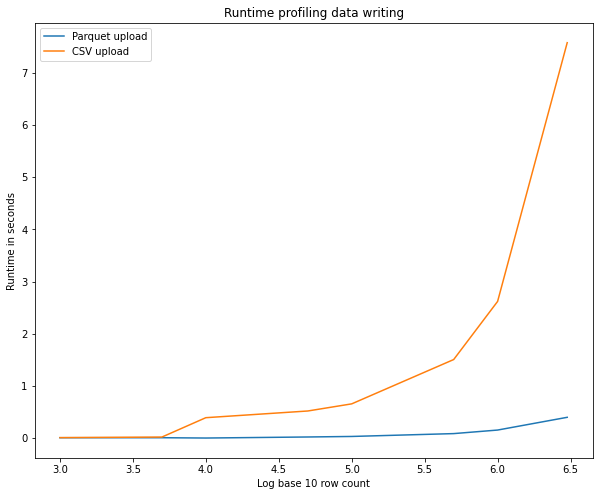

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]

plt.plot(np.log10(upper_bounds), pq_runtimes, label="Parquet upload")
plt.plot(np.log10(upper_bounds), csv_runtimes, label="CSV upload")
plt.xlabel("Log base 10 row count")
plt.ylabel("Runtime in seconds")
plt.legend()
plt.title("Runtime profiling data writing")

## Concepts


### Runtime profiling

We can use functions like timeit and runtime curves to understand how our runtime will evolve with different dataset sizes.

### File formats

- CSV: binary file of data
- Parquet: binary file of data with columnar data.  Divides data into chunks.  Efficient with bigger data.  Pandas needs a parquet engine defined, the default is pyarrow.  There is also fastparquet which is more lightweight. Columnar stores are an order more efficient than row-based storage

https://medium.com/23andme-engineering/genetic-datastore-4b213256db31

https://towardsdatascience.com/understanding-apache-parquet-7197ba6462a9

https://blog.matthewrathbone.com/2019/11/21/guide-to-columnar-file-formats.html

- .xlsx/.xlsm: uses an XML schema which is far more difficult to read than binary
- You can also write to dict and then to .json formats, but in any case binary formats are far faster particularly compared to XML formats

# Pandas and Numpy Operations

https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c

Rule of thumb: vectorize as much as possible and do as little custom functions as possible.  Generally, using pandas and numpy paradigms allows for performance gains as, when possible, the operations will be performed in the LLVM as compiled C code.  

We will apply the concepts above to test runtimes

### Rounding/Vectorization

In [3]:
# Apply round
print("Testing df.apply round")
%timeit df["vals_1"].apply(np.round)

# Just numpy round
print("Testing numpy")
%timeit np.round(df["vals_1"])

# We can also use a trick, +.5 and floor
print("Testing a dataframe arithmetic operation")
%timeit (df["vals_1"]+.5)//1

# What if we used based Python methods?
print("Testing base Python only")
vals_1 = df["vals_1"].to_list()
%timeit [round(x) for x in vals_1]


Testing df.apply round
16.8 s ± 1.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Testing numpy
162 ms ± 5.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing a dataframe arithmetic operation
94.2 ms ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing base Python only
650 ms ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The apply function is explicitly non-vectorized, accesses each element in the dataframe and individually.

WHY IS THE PERFORMANCE GAIN SO HIGH WITH NUMPY? B/c of strict typecasting and implementation of compiled C-code.  We do not have to check for different types aka we are generally sure if there is floating point, integer, or long, and can safely run our C-code, which does not allow for dynamic arrays.

From https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html

- Recall that NumPy’s ND-arrays are homogeneous: an array can only contain data of a single type. For instance, an array can contain 8-bit integers or 32-bit floating point numbers, but not a mix of the two. This is in stark contrast to Python’s lists and tuples, which are entirely unrestricted in the variety of contents they can possess; a given list could simultaneously contain strings, integers, and other objects. This restriction on an array’s contents comes at a great benefit; in “knowing” that an array’s contents are homogeneous in data type, NumPy is able to delegate the task of performing mathematical operations on the array’s contents to optimized, compiled C code. This is a process that is referred to as vectorization. The outcome of this can be a tremendous speedup relative to the analogous computation performed in Python, which must painstakingly check the data type of every one of the items as it iterates over the arrays, since Python typically works with lists with unrestricted contents.


- The Pandas apply is the slowest, because of high overhead and memory associated with the dataframe/pandas series.  The base python implementation is second slowest.  When we call native Pandas and Numpy functions, we can access the compiled C-code for the best runtime.  

Why might the trick be the fastest?

### Datetime manipulation

Almost all structured data involve a timestamp and datetime operations can be extremely costly.  We can improve strongly by smartly interacting with datetimes.

What are some things we can do to best interact with datetimes?

Rule of thumbs:
- pd.to_datetime is your best friend!
- NEVER do .apply

In [59]:
df["dt"] = pd.to_datetime(df["ts"], unit="s")
%timeit pd.to_datetime(df["ts"], unit="s")

78.4 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The .dt. accessor is extremely powerful in accessing native datetime functions, never do df.apply(datetime.func()), but you can see it's still pretty slow as datetime is a large object


In [60]:
%timeit df["dt"].dt.strftime("%Y-%m-%d")


23.4 s ± 1.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
# Let's try a UTC to CST conversion
from dateutil.relativedelta import relativedelta

# Never use this
# print("Non vectorized operation")
# %timeit [dt + relativedelta(hours=6) for dt in df["dt"]]
print("Pandas vectorized operation")
%timeit df["dt"] + pd.to_timedelta(6,'h') 
print("Simply utilize timestamps")
%timeit df["ts"]+3600*6

Pandas vectorized operation
35.9 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Simply utilize timestamps
3.35 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


At the basis of any datetime based function is probably a Unix timestamp of some precision.  These timestamps start at 1970-01-01 as 0 seconds and can be some set precision (in our example, seconds).  This allows for us to easily perform computations with floating point or integer vs more complex datetime data structures.

Also, the pd.to_datetime() function returns the pd.Timestamp object, analogous to the native datetime.datetime object, and not to be confused with the Unix timestamps 

In [83]:
print(df["dt"].iloc[0].timestamp())

1600000000.0


In [95]:
# Converting back from pd.Timestamp to datetime, just evoke .astype() to a numpy int64 with ns precision
print("The runtime cost of conversion")
%timeit df["dt"].astype(np.int64)
print("The total runtime is still lower than vectorized datetime operations")
%timeit df["dt"].astype(np.int64)/1000000000+3600*6


The runtime cost of conversion
8.55 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The total runtime is still lower than vectorized datetime operations
31 ms ± 4.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Custom functions, algorithmic thinking

I want to quantify if vals_1 is a random walk, and the path that vals_1 moves on.  

To do this, I want to solve for a moving counter $C_t$ that starts at 0.

$C_0=0$

At every $X_t$, solve for $X_t-X_{t-1}$

If $X_t-X_{t-1} > 0, C_t = C_{t-1} + 1$

Else if $X_t-X_{t-1} < 0, C_t = C_{t-1} - 1$

Else $C_t = C_{t-1} $ 

where X is vals_1

Basically, subtract the last value from the current value and add 1 to a counter if it's greater than 0, subtract 1 if less, and keep same if 0.  The array should already be sorted by ts, so simply operate on vals_1.  Keep a running total and project it to the dataset.

In [103]:
### Try it yourself and time it

def custom_walk(## Decide your input):
    return 
    
%timeit custom_walk(## Decide your input)

In [104]:
### Solutions follow, please try yourself before referencing!
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [26]:
# Simple Pythonic solution
def walk(vals):
    results = []
    last_val = vals[0]
    counter = 0
    for val in vals:
        delta = val-last_val
        counter = counter+1 if delta>0 else counter-1 if delta<0 else counter
        results.append(counter)
        last_val = val
    return results

# Using iterrows
def walk_df(df):
    results = []
    last_val = df["vals_1"].iloc[0]
    counter = 0    
    for i, row in df.iterrows():
        val = row["vals_1"]
        delta = val-last_val
        counter = counter+1 if delta>0 else counter-1 if delta<0 else counter
        results.append(counter)
        last_val = val
    return counter   

# Using series.items
def walk_series(series):
    results = []
    last_val = series[0]
    counter = 0    
    for i, val in series.items():
        delta = val-last_val
        counter = counter+1 if delta>0 else counter-1 if delta<0 else counter
        results.append(counter)
        last_val = val
    return counter   


# Vectorized solution
def vectorized_walk(series):
    vals = np.insert(series[1:]-series[:-1], 0, 0)
    return np.cumsum(np.where(vals>0, 1, -1)+np.where(vals==0,1,0))

# We can access the LLVM with numba
@njit
def compiled_walk(vals):
    results = np.zeros(len(vals))
    last_val = vals[0]
    counter = 0
    for i, val in enumerate(vals):
        delta = val-last_val
        counter = counter+1 if delta>0 else counter-1 if delta<0 else counter
        results[i] = counter
        last_val = val
    return results

# What if we parallelized?
@njit(parallel=True)
def parallel_compiled_walk(vals):
    results = np.zeros(len(vals))
    last_val = vals[0]
    counter = 0
    for i, val in enumerate(vals):
        delta = val-last_val
        counter = counter+1 if delta>0 else counter-1 if delta<0 else counter
        results[i] = counter
        last_val = val
    return results


In [27]:
print("Iterrows, so slow don't do\n")
#%timeit walk_df(df)
print("Iterate through items in a series")
%timeit walk_series(df["vals_1"])
print("Iterate over array with simple Python")
%timeit walk(df["vals_1"])
vals_1 = df["vals_1"].tolist()
vals_1_np = df["vals_1"].to_numpy()
print("Iterate over a list")
%timeit walk(vals_1)
print("We can actually fully vectorize this problem")
%timeit vectorized_walk(vals_1_np)
print("We can access the assembly via numba and the LLVM")
%timeit compiled_walk(vals_1_np)
print("What if we parallelized it?")
%timeit parallel_compiled_walk(vals_1_np)


Iterrows, so slow don't do

Iterate through items in a series
1.2 s ± 68.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Iterate over array with simple Python
1.14 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Iterate over a list
728 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
We can actually fully vectorize this problem
46.9 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
We can access the assembly via numba and the LLVM
20.8 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
What if we parallelized it?
16.9 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
n_ints = [100000, 1000000, 10000000, 100000000]

args = [[np.random.rand(n)] for n in n_ints]
kwargs = [{} for upper in n_ints]

walk_runtimes =[elapsed.total_seconds() for 
                elapsed in profile_runtimes([walk for _ in n_ints], args, kwargs)]
vectorized_walk_runtimes =[elapsed.total_seconds() for 
                           elapsed in profile_runtimes([vectorized_walk for _ in n_ints], args, kwargs)]
compiled_walk_runtimes =[elapsed.total_seconds() for 
                elapsed in profile_runtimes([compiled_walk for _ in n_ints], args, kwargs)]
parallel_compiled_walk_runtimes = [elapsed.total_seconds() for 
                elapsed in profile_runtimes([parallel_compiled_walk for _ in n_ints], args, kwargs)]

Text(0.5, 1.0, 'Profiling our functions')

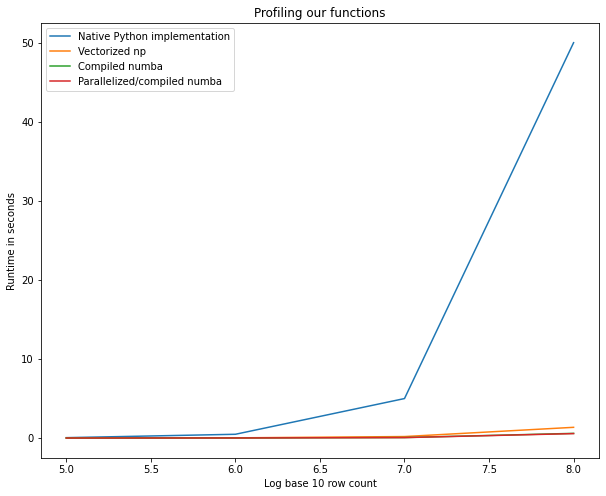

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]

plt.plot(np.log10(n_ints), walk_runtimes, label="Native Python implementation")
plt.plot(np.log10(n_ints), vectorized_walk_runtimes, label="Vectorized np")
plt.plot(np.log10(n_ints), compiled_walk_runtimes, label="Compiled numba")
plt.plot(np.log10(n_ints), parallel_compiled_walk_runtimes, label="Parallelized/compiled numba")

plt.xlabel("Log base 10 row count")
plt.ylabel("Runtime in seconds")
plt.legend()
plt.title("Profiling our functions")

Text(0.5, 1.0, 'Profiling our functions')

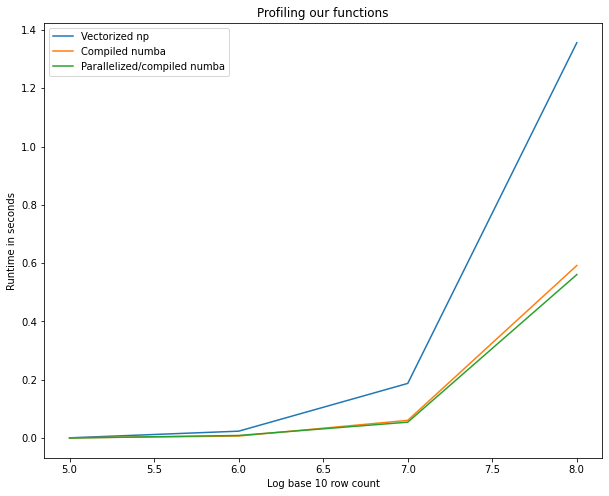

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]

#plt.plot(np.log10(n_ints), walk_runtimes, label="Native Python implementation")
plt.plot(np.log10(n_ints), vectorized_walk_runtimes, label="Vectorized np")
plt.plot(np.log10(n_ints), compiled_walk_runtimes, label="Compiled numba")
plt.plot(np.log10(n_ints), parallel_compiled_walk_runtimes, label="Parallelized/compiled numba")

plt.xlabel("Log base 10 row count")
plt.ylabel("Runtime in seconds")
plt.legend()
plt.title("Profiling our functions")


### Key takeaways

1. Iterrows is so slow, you should almost never use it


2. series.items is better, but we want to not use Pandas series if possible.  Because of the complex data structures Pandas offers, if we arbitrarily try to iterate over Pandas objects we lose a lot of performance compared to core Pandas functions which are optimized for said structures.  


3. If we need to perform iterations, we should do it via simple Python lists (which are highly optimized) or numpy arrays (which are strictly typed and have less overhead than Pandas series).


4. For maximum performance, we should vectorize as much of the problem with native numpy or pandas functions as possible (several pandas functions are actually just simply calling numpy).  Even if we cannot vectorize the entire problem bc of extremely custom logic, there is bound to be portions that we can.


5. Inherently, even when "vectorizing" is better than "iterating," at the compiler level we are still "looping through" the data structure.  The most optimal performance is actually just to bypass the Python interpreter and compile our code to machine instructions.  This is achieved by invoking paradigms like numba or cython, which are interfaces to translate Python code to machine-compiled instructions via LLVM, a language agnostic middleware.  The tradeoff is a loss of functionality, as we are restricted to numpy data structures and base Python functions.

https://numba.pydata.org/

https://cython.org/

6. If it's still too slow, you probably need more RAM or need to just write it in C/C++.  


## Parallelization

In the previous example why DIDN'T the numba parallelization simply divide the runtime by an order of 1 or 2? 

https://zetcode.com/python/multiprocessing/

https://github.com/pydata/numexpr

In [33]:
# 500 mill float big array
big_array = np.random.rand(100000000)

In [37]:
print("What is the runtime without parallelization?")
%timeit np.sin(big_array)

What is the runtime without parallelization?
770 ms ± 55.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
import numexpr as ne

print("What is the runtime with parallelization?")
%timeit ne.evaluate('sin(big_array)')


What is the runtime without parallelization?
174 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Numexpr not only does max parallelization with cores (in this case, 4 cores), but also does more efficient memory allocation with less caching.  This is how we achieve >4x speed improvement.  

We can use numexpr on numpy specific functions for performance gains, and simply use multiprocessing engine otherwise.  

Useful paradigms in multiprocessing:
- Process: define a worker
- Pool: define a set of workers 
- Map: distributes a set of inputs amongst functions


What is the technical limit of performance gain from multiprocessing? 

Supposed I have a machine with n cores and a total runtime T and an input data size of m.  

$T(m) = A(m) + C(m)$

where $A(m)$ is independent, parallelizable runtime and $C(m)$ is dependent, synchronous runtime (un-parallelizable).

The maximum achievable performance gain from parallelization is:

$ T(m) = A(m)/n + C(m)$

Note that runtime will almost always increase monotonically with the input data size by some order.

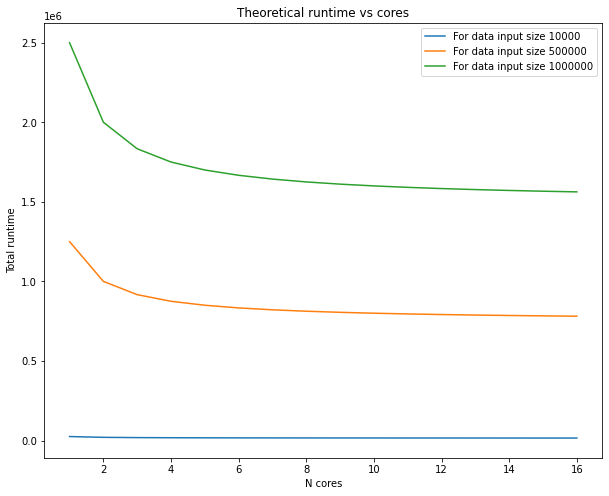

In [44]:
input_size = [10000, 500000, 1000000]
a = lambda x: 1.5*x
c = lambda x: x
cores = [i for i in range(1, 17)]

for m in input_size:
    total_runtime = [a(m)+c(m)/n for n in cores]
    plt.plot(cores, total_runtime, label=f"For data input size {m}")

plt.xlabel("N cores")
plt.ylabel("Total runtime")
plt.title("Theoretical runtime vs cores")
plt.legend()